# Zillow Dataset Clustering Exercises

Create a python script or jupyter notebook named ```explore_zillow``` and do the following:

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

2. Answer those questions through a mix of statistical tests and visualizations.

In your exploration, be sure you include the following:

1. a plot with at least 3 dimensions, such as x, y, and color.

2. at least 3 different **types** of plots (like box, scatter, bar, ...)

3. at least 2 statistical tests.

4. document takeaways/conclusions after each question is addressed.

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [37]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale, isolation_forest, concat_dfs, my_RFE


# default viz size settings
plt.rc('figure', figsize=(13, 11))
plt.rc('font', size=13)

# default pandas decimal number display format
#pd.options.display.float_format = '{:20,.2f}'.format

In [6]:
# acquire the zillow data
df = get_zillow_data()
df.shape

(77614, 69)

In [7]:
df = prepare_zillow(df)
df.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
14297519,3.5,3100.0,33634931.0,-117869207.0,1,1998.0,1023282.0,0.025595,7.5,199.0,19.0
17052889,1.0,1465.0,34449266.0,-119281531.0,2,1967.0,464000.0,0.055619,3.0,196.0,19.0
14186244,2.0,1243.0,33886168.0,-117823170.0,1,1962.0,564778.0,0.005383,5.0,196.0,19.0


In [8]:
# main split
train, validate, test = zillow_main_split(df)

In [9]:
train.shape

(29285, 11)

In [12]:
train = impute_nulls(train)
validate = impute_nulls(validate)
test = impute_nulls(test)

In [13]:
train.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'logerror', 'bathbedcnt', 'decade', 'century'],
      dtype='object')

Text(0.5, 1.0, "Is logerror significantly different for properties in\nLA County vs Orange County vs Ventura County\nand/or by it's Year built and Century built?")

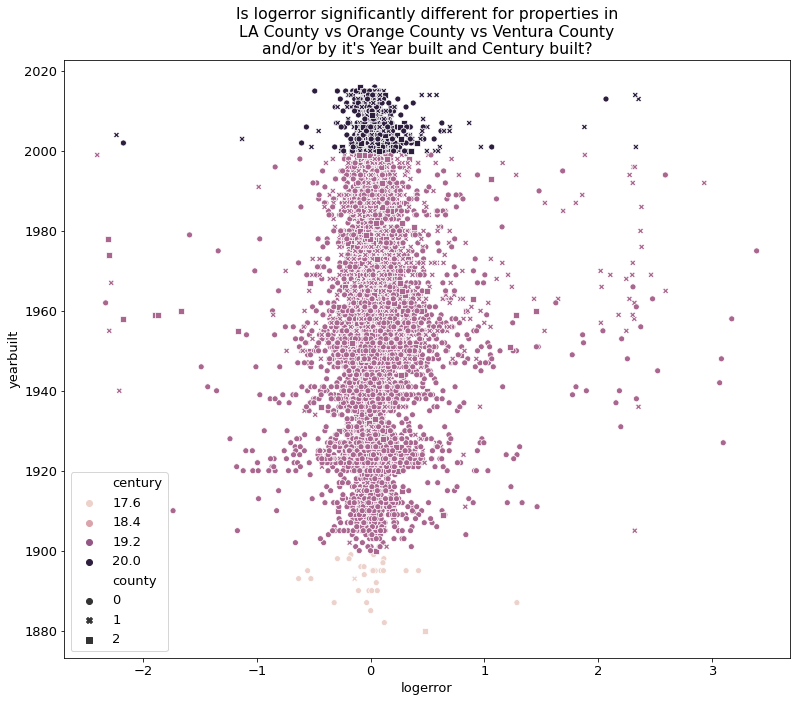

In [40]:
sns.scatterplot(data=train, x="logerror", y="yearbuilt", hue="century", style="county")
plt.title("Is logerror significantly different for properties in\nLA County vs Orange County vs Ventura County\nand/or by it's Year built and Century built?")

In [25]:
scaler, train_scaled, validate_scaled, test_scaled = zillow_scale(train, validate, test)
train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
13060986,0.181818,0.136470,0.467473,0.869519,0.0,0.625000,0.024387,0.411497,0.30,0.615385,0.5
14323887,0.636364,0.534787,0.176194,0.847578,0.5,0.852941,0.125694,0.418184,0.65,0.846154,0.5
11921805,0.181818,0.103838,0.535039,0.724188,0.0,0.375000,0.038083,0.417980,0.25,0.384615,0.5


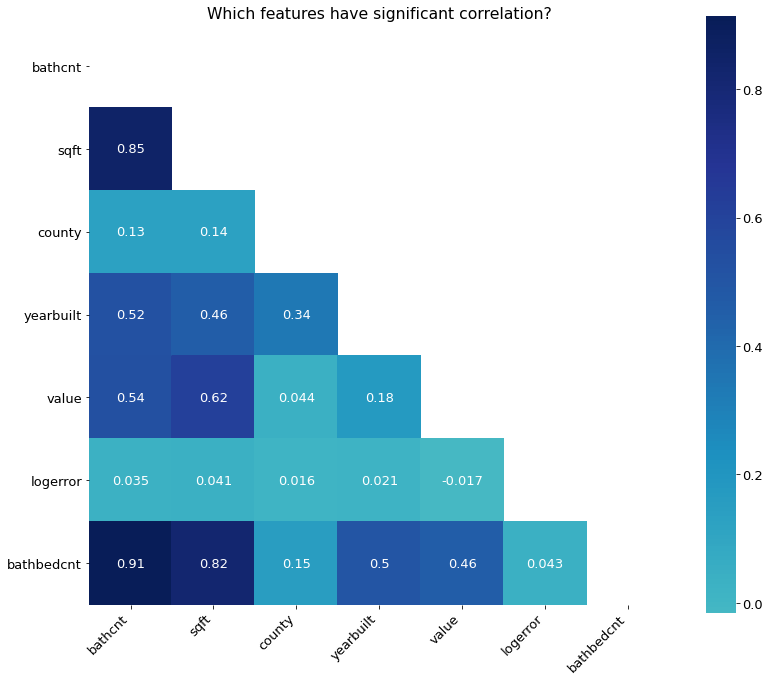

In [41]:
heatmap_data = train_scaled.drop(columns=['latitude', 'longitude', 'decade', 'century'])
corr = heatmap_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, center=0, cmap='YlGnBu', square=True, annot=True) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title('Which features have significant correlation?')
ax

In [34]:
train['yearbuiltbins'] = pd.cut(train['yearbuilt'], bins=6, precision=0)
train.head()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century,yearbuiltbins
parcelid,,,,,,,,,,,,
13060986,2.0,2219.0,34031614.0,-117805261.0,0,1965.0,585000.0,-0.019244,6.0,196.0,19.0,"(1948.0, 1971.0]"
14323887,7.0,8322.0,33601061.0,-117847406.0,1,1996.0,3001705.0,0.019547,13.0,199.0,19.0,"(1993.0, 2016.0]"
11921805,2.0,1719.0,34131487.0,-118084411.0,0,1931.0,911736.0,0.018360,5.0,193.0,19.0,"(1925.0, 1948.0]"
11504971,3.0,2350.0,33896023.0,-118403192.0,0,1966.0,122559.0,0.049516,8.0,196.0,19.0,"(1948.0, 1971.0]"
11603399,3.0,2816.0,34040252.0,-118397448.0,0,1951.0,1888364.0,0.014896,7.0,195.0,19.0,"(1948.0, 1971.0]"


Text(0.5, 1.0, 'Which year built bins have more log error?')

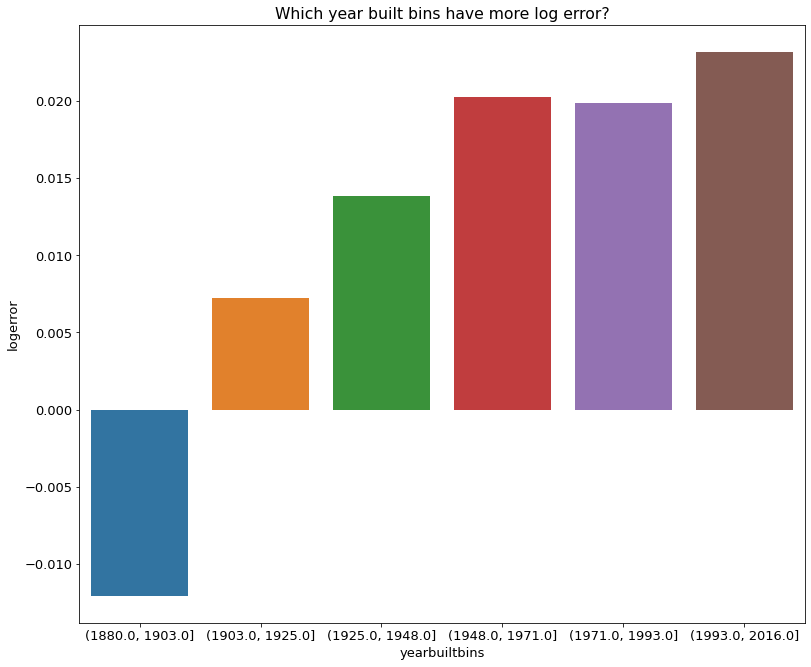

In [38]:
sns.barplot(x = 'yearbuiltbins', y = 'logerror', data = train, ci = None).set_title("Which year built bins have more log error?")

Text(0.5, 1.0, 'Do properties with a higher bath+bed count have significantly more log error?')

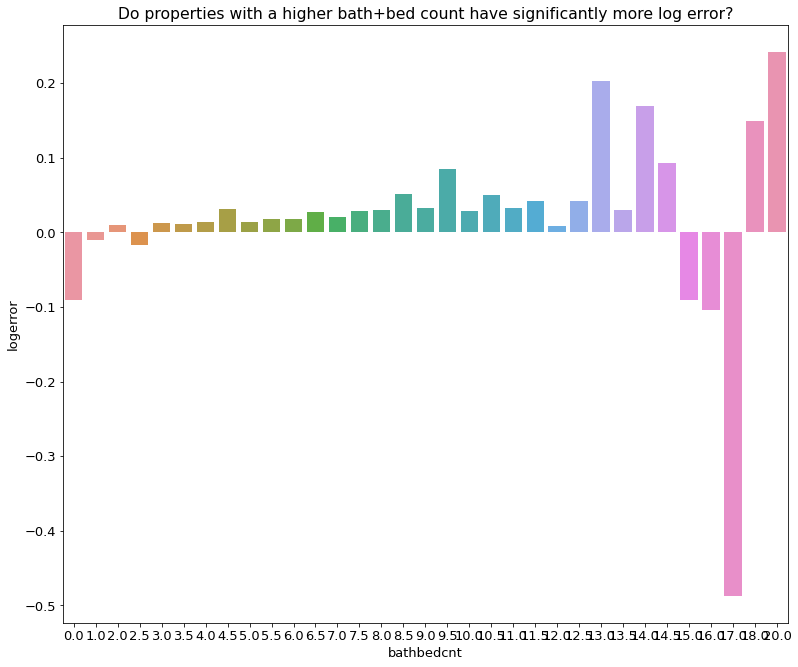

In [44]:
sns.barplot(x = 'bathbedcnt', y = 'logerror', data = train, ci = None).set_title("Do properties with a higher bath+bed count have significantly more log error?")

### Is there a significant difference in the log error of Zestimates on properties that have 9 or higher bath + bed count and the overall log error?

$
\begin{align*}
   H_0 & : \text{There is no difference in Zestimate log error in properties that have 9 or higher bath + bed count and the overall log error.}
   \\
   H_a & : \text{There is a difference in Zestimate log error in properties that have 9 or higher bath + bed count and the overall log error.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

In [68]:
alpha = 0.05
lotsofrooms = train[train.bathbedcnt >= 9.0]

t, p = stats.ttest_1samp(lotsofrooms.logerror, train.logerror.mean())

print(f't = {t:.5f}')
print(f'p = {p:.5f}')

null_hypothesis = 'there is no difference in Zestimate log error in properties that have 9 or higher bath + bed count and the overall log error.'

if p < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

t = 4.15041
p = 0.00003
We reject the hypothesis that there is no difference in Zestimate log error in properties that have 9 or higher bath + bed count and the overall log error.
